In [80]:
%matplotlib widget
import os
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
from IPython.display import Image, display
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import find_peaks
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gsp
plt.rcParams.update({'font.size': 5})

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

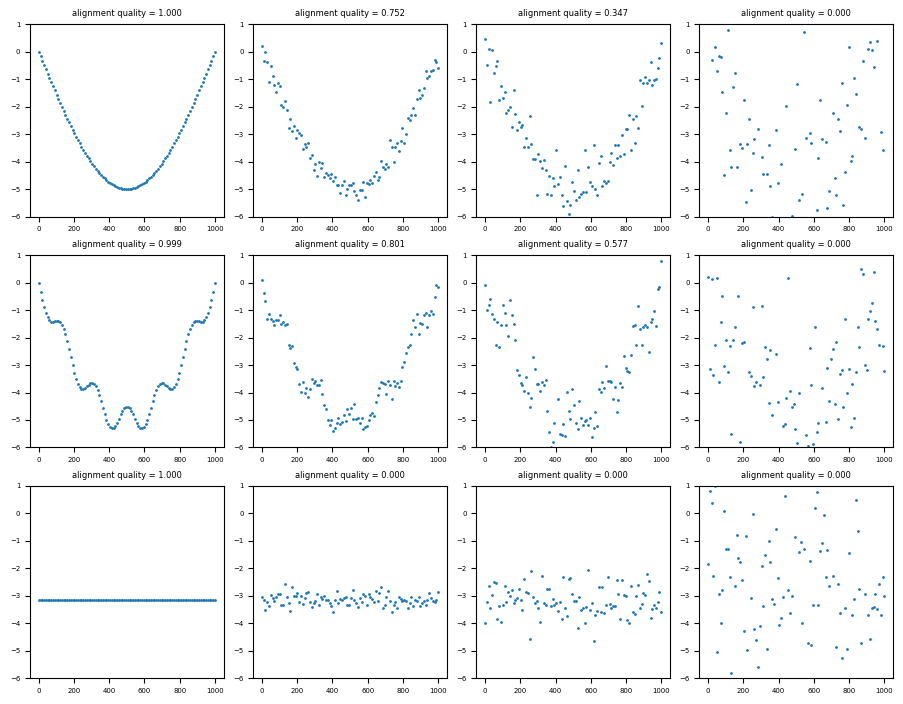

In [83]:
maxx = 1000
nx = 100
a = 5

x = np.linspace(0,maxx,nx)
y_ordered = -np.sin(x/maxx*np.pi)*a
noise_scale = [0.2, 0.5, 2.0]

y1 = y_ordered 
y2 = y_ordered - np.sin(np.sin(x/maxx*np.pi*11)*a/10)
y3 = 0*y_ordered + np.mean(y_ordered)
ys = [[y1], [y2], [y3]]

nrows = 3
ncols = len(noise_scale)+1

for i in range(len(noise_scale)):
    for j in range(len(ys)):
        ys[j].append(ys[j][0] + np.random.normal(loc=0, scale=noise_scale[i], size=x.shape))

        
def get_alignment_qual(h_vals, change_tolerance=0.01):
    diffs = np.diff(h_vals)
    std = np.std(h_vals)
    dirchange = np.abs(np.diff(np.sign(diffs))) > 1
    total_distance = 0.0
    for i,changed in enumerate(dirchange):
        change1 = np.clip(np.abs(diffs)[i  ] - change_tolerance, 0.0, None)
        change2 = np.clip(np.abs(diffs)[i+1] - change_tolerance, 0.0, None)
        if changed: total_distance += (change1 + change2)/2
    fraction_of_totally_random = 1 - (2.0* total_distance / (std * (nx-1)))
    qual_alignment = np.clip(fraction_of_totally_random, 0, 1)
    
    return qual_alignment


fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=[9, 7], dpi=100)
for i in range(nrows*ncols):
    row, col = int(i/ncols), i%ncols
    ax = axs[row, col]
    y_vals = ys[row][col]
    ax.scatter(x, y_vals, s=1)
    ax.set_title('alignment quality = %.3f' % get_alignment_qual(y_vals))
    ax.set_ylim([-a*1.2, 1])
fig.tight_layout()
plt.close()
display(fig)

function for plotting

In [12]:
#-------------------------------------------------------------------------------------
def plot_detected(self, fig_dir='figs', verbose=False, min_width=100, min_depth=1.5, print_mframe_info=True):
    
    import matplotlib
    from matplotlib.patches import Rectangle
    
    if len(self.detection_2nd_returns['h'])>0:
        lake_minh = np.min(self.detection_2nd_returns['h'])
    else: return
    lake_max_depth = np.abs(self.main_peak - np.min(self.detection_2nd_returns['h']))
    lake_segment_length = np.abs(np.max(self.detection_2nd_returns['xatc']) - np.min(self.detection_2nd_returns['xatc']))
    lake_maxh = np.min((self.mframe_data['peak'].max(), self.main_peak+3*lake_max_depth))
    buffer_bottom = np.max((0.5*lake_max_depth, 2.0))
    lake_minh_plot = lake_minh - buffer_bottom
    buffer_top = (lake_maxh - lake_minh_plot) * 0.5
    # buffer_top = np.max((0.5*lake_max_depth, 2.0))
    lake_maxh_plot = lake_maxh + buffer_top
    ylms = (lake_minh_plot, lake_maxh_plot)
    xlms = (0.0, self.mframe_data.xatc_max.max())

    if (lake_max_depth > min_depth) & (lake_segment_length > min_width):
        fig, ax = plt.subplots(figsize=[9, 5], dpi=100)
        
        # plot the ATL03 photon data
        scatt = ax.scatter(self.photon_data.xatc, self.photon_data.h,s=5, c=self.photon_data.snr, alpha=1, 
                           edgecolors='none', cmap=cmc.lajolla, vmin=0, vmax=1)
        p_scatt = ax.scatter([-9999]*4, [-9999]*4, s=15, c=[0.0,0.25,0.75,1.0], alpha=1, edgecolors='none', cmap=cmc.lajolla, 
                             vmin=0, vmax=1, label='ATL03 photons')
        # ax.scatter(self.photon_data.xatc, self.photon_data.h, s=3, c='k', alpha=1, edgecolors='none')

        # plot surface elevation
        for xtent in self.surface_extent_detection:
            ax.plot(xtent, [self.surface_elevation, self.surface_elevation], 'g-', lw=3)
        p_surf_elev, = ax.plot([-9999]*2, [-9999]*2, 'g-', lw=3, label='lake surface')
            
        # plot the second returns from detection
        for j, prom in enumerate(self.detection_2nd_returns['prom']):
            ax.plot(self.detection_2nd_returns['xatc'][j], self.detection_2nd_returns['h'][j], 
                                    marker='o', mfc='none', mec='b', linestyle = 'None', ms=prom*8)
        p_2nd_return, = ax.plot(-9999, -9999, marker='o', mfc='none', mec='b', ls='None', ms=3, label='second returns')
        
        # plot mframe bounds
        ymin, ymax = ax.get_ylim()
        mframe_bounds_xatc = list(self.mframe_data['xatc_min']) + [self.mframe_data['xatc_max'].iloc[-1]]
        for xmframe in mframe_bounds_xatc:
            ax.plot([xmframe, xmframe], [ymin, ymax], 'k-', lw=0.5)
        
        # visualize which segments initially passed
        for i, passing in enumerate(self.mframe_data['lake_qual_pass']):
            mf = self.mframe_data.iloc[i]
            if passing:
                xy = (mf.xatc_min, ylms[0])
                width = mf.xatc_max - mf.xatc_min
                height = ylms[1] - ylms[0]
                rct = Rectangle(xy, width, height, ec=(1,1,1,0), fc=(0,0,1,0.1), zorder=-1000, label='major frame passed lake check')
                p_passed = ax.add_patch(rct)
            p_mfpeak, = ax.plot((mf.xatc_min,mf.xatc_max), (mf.peak,mf.peak),'k-',lw=0.5, label='major frame peak')
        
        # add a legend
        hdls = [p_scatt, p_surf_elev, p_2nd_return, p_mfpeak, p_passed]
        ax.legend(handles=hdls, loc='lower left', fontsize=7, scatterpoints=4)
        
        # add the colorbar 
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='4%', pad=0.05)
        cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
        cbar.ax.get_yaxis().set_ticks([])
        for j, lab in enumerate([0.2, 0.4, 0.6, 0.8]):
            cbar.ax.text(.5, lab, '%.1f'%lab, ha='center', va='center', fontweight='black')
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.set_ylabel('photon density', rotation=270, fontsize=8)
        
        # add labels and description in title
        txt  = 'ICESat-2 Lake Detection: %s, ' % ('Greenland Ice Sheet' if self.lat>=0 else 'Antarctic Ice Sheet')
        txt += '%s Melt Season' % self.melt_season
        fig.suptitle(txt, y=0.95, fontsize=14)
        
        txt  = 'location: %s, %s (area: %s) | ' % (self.lat_str, self.lon_str, self.polygon_name)
        txt += 'time: %s UTC | surface elevation: %.2f m\n' % (self.date_time, self.surface_elevation)
        txt += 'RGT %s %s cycle %i | ' % (self.rgt, self.gtx.upper(), self.cycle_number)
        txt += 'beam %i (%s, %s spacecraft orientation) | ' % (self.beam_number, self.beam_strength, self.sc_orient)
        txt += 'granule ID: %s' % self.granule_id
        ax.set_title(txt, fontsize=8)

        ax.set_ylabel('elevation above geoid [m]',fontsize=8)
        # ax.set_xlabel('along-track distance [m]',fontsize=8, labelpad=0)
        ax.tick_params(axis='x', which='major', labelsize=7)
        ax.tick_params(axis='y', which='major', labelsize=6)
        
        # set limits
        ax.set_ylim(ylms)
        ax.set_xlim(xlms)
        
        # add latitude
        #_________________________________________________________
        lx = self.photon_data.sort_values(by='lat').iloc[[0,-1]][['lat','xatc']].reset_index(drop=True)
        lat = np.array(lx.lat)
        xatc = np.array(lx.xatc)
        def forward(x):
            return lat[0] + x * (lat[1] - lat[0]) / (xatc[1] - xatc[0])
        def inverse(l):
            return xatc[0] + l * (xatc[1] - xatc[0]) / (lat[1] - lat[0])
        secax = ax.secondary_xaxis(-0.065, functions=(forward, inverse))
        secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        secax.set_xlabel('latitude / along-track distance',fontsize=8,labelpad=0)
        secax.tick_params(axis='both', which='major', labelsize=7)
        secax.ticklabel_format(useOffset=False) # show actual readable latitude values
        
        # rename x ticks
        xticklabs = ['%g km' % (xt/1000) for xt in list(ax.get_xticks())]
        ticks = ax.get_xticks()
        ax.set_xticks(ticks)
        ax.set_xticklabels(xticklabs)
        
        fig.tight_layout()
        
        # add mframe info text
        if print_mframe_info:
            for i,loc in enumerate(self.mframe_data['xatc_min']):
                mf = self.mframe_data.iloc[i]
                txt  = 'mframe: %i\n' % (mf.name%1000)
                txt += 'photons: %i\n' % mf.n_phot
                txt += 'peak: %.2f\n' % mf.peak
                txt += 'flat: %s\n' % ('Yes.' if mf.is_flat else 'No.')
                txt += 'SNR surf: %i\n' % np.round(mf.snr_surf)
                txt += 'SNR up: %i\n' % np.round(mf.snr_upper)
                txt += 'SNR low: %i\n' % np.round(mf.snr_lower)
                txt += '2nds: %i%%\n' % np.round(mf.ratio_2nd_returns*100)
                txt += '2nds strength: %.2f\n' % mf.quality_secondreturns
                txt += '2nds number: %.2f\n' % mf.length_penalty
                txt += '2nds spread: %.2f\n' % mf.range_penalty
                txt += '2nds align: %.2f\n' % mf.alignment_penalty
                txt += '2nds quality: %.2f\n' % mf.quality_summary
                txt += 'pass: %s' % ('Yes.' if mf.lake_qual_pass else 'No.')
                trans = ax.get_xaxis_transform()
                bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
                ax.text(loc+5, 0.99, txt, transform=trans, fontsize=3, va='top', bbox=bbox)

        # save figure
        if not os.path.exists(fig_dir): os.makedirs(fig_dir)
        epoch = self.mframe_data['dt'].mean() + datetime.datetime.timestamp(datetime.datetime(2018,1,1))
        dateid = datetime.datetime.fromtimestamp(epoch).strftime("%Y%m%d-%H%M%S")
        granid = self.granule_id[:-3]
        latid = '%dN'%(int(np.round(self.lat*1e5))) if self.lat>=0 else '%dS'%(-int(np.round(self.lat*1e5)))
        lonid = '%dE'%(int(np.round(self.lon*1e5))) if self.lon>=0 else '%dW'%(-int(np.round(self.lon*1e5)))
        figname = fig_dir + '/lake_%s_%s_%s_%s-%s.jpg' % (self.polygon_name, granid, self.gtx, latid, lonid)
        fig.patch.set_facecolor('white')
        fig.tight_layout()
        fig.savefig(figname, dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close(fig)

        return fig

In [16]:
plt.close('all')

searchfor = 'testdata79N_test_'
filelist = ['pickles/'+f for f in os.listdir('pickles') \
            if os.path.isfile(os.path.join('pickles', f)) & (searchfor in f)]
filelist= filelist[:10] 

In [26]:
class dict2class(object):
    def __init__(self, my_dict):
        for key in my_dict:
            setattr(self, key, my_dict[key])

lakelist = []
for filename in filelist:
    with open(filename, 'rb') as f:
        lk = pickle.load(f)
    lk['len_subsegs'] = 14.2
    lakelist.append(dict2class(lk))

In [75]:
# get a quality summary and order list by it

# percent of mfs passing out of all mfs fully included in extent
# average of prominences of second peaks in extent (absence counted a zero)
# alignment: penalize randomness , need to find a good way to normalize it
# length of lake (capped at 2km)
# depth of lake (75th percentile?, cap at 5 meters?)

# if (len(elev_2ndpeaks) > 2) & (ratio_2nd_returns > min_ratio_2nd_returns):
# h_range = np.max(elev_2ndpeaks) - np.min(elev_2ndpeaks)
# diffs = np.diff(elev_2ndpeaks)
# dirchange = np.abs(np.diff(np.sign(diffs))) > 1
# total_distance = 0.0
# for i,changed in enumerate(dirchange):
#     if changed: total_distance += (np.abs(diffs)[i] + np.abs(diffs)[i+1])/2
# alignment_penalty = 1.0 if total_distance==0 else\
#                     np.clip(np.clip(h_range, 0.5, None) / (total_distance + np.clip(h_range, 0.5, None)), 0, 1)
# range_penalty = np.clip(1/math.log(np.clip(h_range,1.1,None),5), 0, 1)
# length_penalty = (len(elev_2ndpeaks) / n_subsegs)**1.5
# quality_secondreturns = np.clip(np.mean(prominences) * ((np.clip(2*len(elev_2ndpeaks)/n_subsegs, 1, None)-1)*2+1), 0, 1)
# quality_summary = alignment_penalty * length_penalty * range_penalty * quality_secondreturns


def calc_quality_lake(self, min_2nd_returns=7, len_qual_limit=3000.0, depth_qual_limit=10.0,
                      depth_determination_percentile=80, verbose=False):
    
    min_2nd_returns = 7
    len_qual_limit = 3000.0
    depth_qual_limit = 10.0
    depth_determination_percentile = 80
    quality_lake = 0.0
    quality_props = {'mean_strength_2nd_returns': 0.0,
                     'lake_length': 0.0,
                     'lake_depth': 0.0,
                     'qual_alignment': 0.0
                    }
    
    n_second_returns = len(self.detection_2nd_returns['h'])
    if n_second_returns >= min_2nd_returns:
        
        # length (cap at a kilometer)
        length_extent = 0
        for ext in self.surface_extent_detection:
            length_extent += (np.max(ext) - np.min(ext))
        qual_lake_length = np.clip((length_extent/len_qual_limit)**0.5, 0, 1)
        quality_props['lake_length'] = np.clip(qual_lake_length, 0, 1)
        
        # depth (cap at 10)
        depth = np.percentile(np.abs(self.detection_2nd_returns['h'] - self.surface_elevation), depth_determination_percentile)
        qual_lake_depth = np.clip(((depth-1.0)/(depth_qual_limit-1.0))**0.8, 0, 1)
        quality_props['lake_depth'] = np.clip(qual_lake_depth, 0, 1)
        
        # average of prominences of second peaks in extent (absence counted a zero)
        qual_strength_2nd_returns = np.sum(self.detection_2nd_returns['prom']) / (length_extent / self.len_subsegs)
        qual_strength_2nd_returns = qual_strength_2nd_returns ** 0.3
        quality_props['strength_2nd_returns'] = np.clip(qual_strength_2nd_returns, 0, 1)
        
        # alignment: penalize randomness , need to find a good way to normalize it
        range_2nds = np.max(self.detection_2nd_returns['h']) - np.min(self.detection_2nd_returns['h'])
        diffs = np.diff(self.detection_2nd_returns['h'])
        dirchange = np.abs(np.diff(np.sign(diffs))) > 1
        total_distance = 0.0
        for i,changed in enumerate(dirchange):
            if changed: total_distance += (np.abs(diffs)[i] + np.abs(diffs)[i+1])/2
        fraction_of_totally_random = 1 - (2 * total_distance / (range_2nds * (n_second_returns-1)))
        qual_alignment = fraction_of_totally_random**3
        quality_props['qual_alignment'] = np.clip(qual_strength_2nd_returns, 0, 1)
        
        total_quality = quality_props['lake_length'] * quality_props['lake_depth'] * \
                        quality_props['strength_2nd_returns'] * quality_props['qual_alignment']
        
        self.detection_quality_info = quality_props
        self.detection_quality = total_quality
        
        if verbose: 
            print('          lake_depth: %5.2f m -->  %4.2f' % (depth, qual_lake_depth))
            print('         lake_length: %5i m -->  %4.2f' % (length_extent, qual_lake_length))
            print('strength_2nd_returns:             %5.2f' % qual_strength_2nd_returns)
            print('      qual_alignment:             %5.2f' % qual_alignment)
            print('       TOTAL QUALITY:             %5.2f' % total_quality)
            print('____________________________________________________________________________________________')
            print(' ')


          lake_depth: 10.93 m -->  1.00
         lake_length:  1943 m -->  0.80
strength_2nd_returns:              0.46
      qual_alignment:              0.80
       TOTAL QUALITY:              0.17
____________________________________________________________________________________________
 


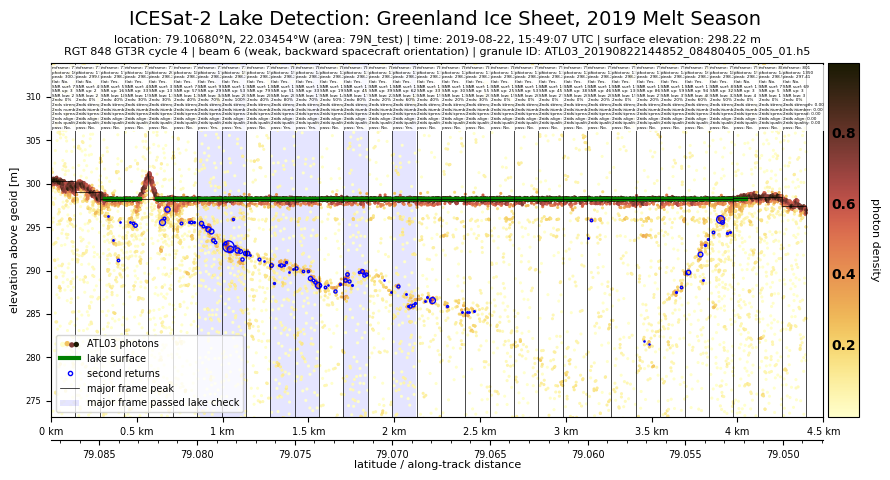

          lake_depth: 10.16 m -->  1.00
         lake_length:  3634 m -->  1.00
strength_2nd_returns:              0.49
      qual_alignment:              0.84
       TOTAL QUALITY:              0.24
____________________________________________________________________________________________
 


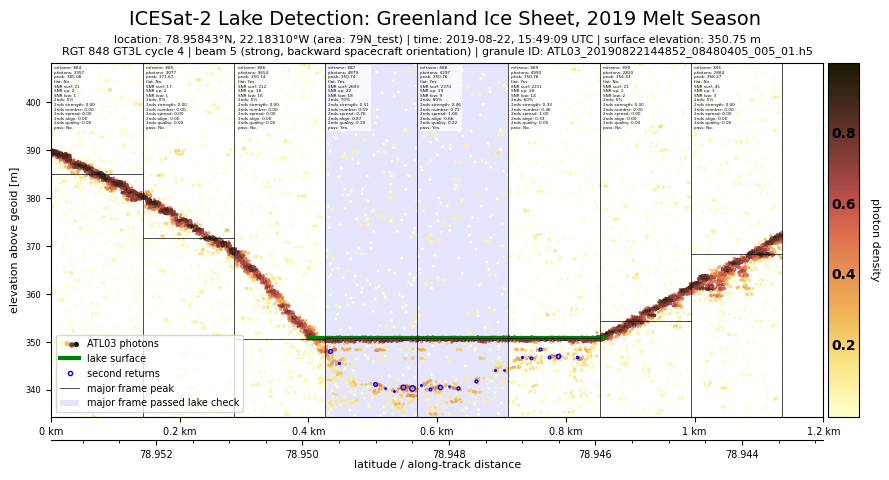

          lake_depth: 10.25 m -->  1.00
         lake_length:   457 m -->  0.39
strength_2nd_returns:              0.57
      qual_alignment:              0.70
       TOTAL QUALITY:              0.13
____________________________________________________________________________________________
 


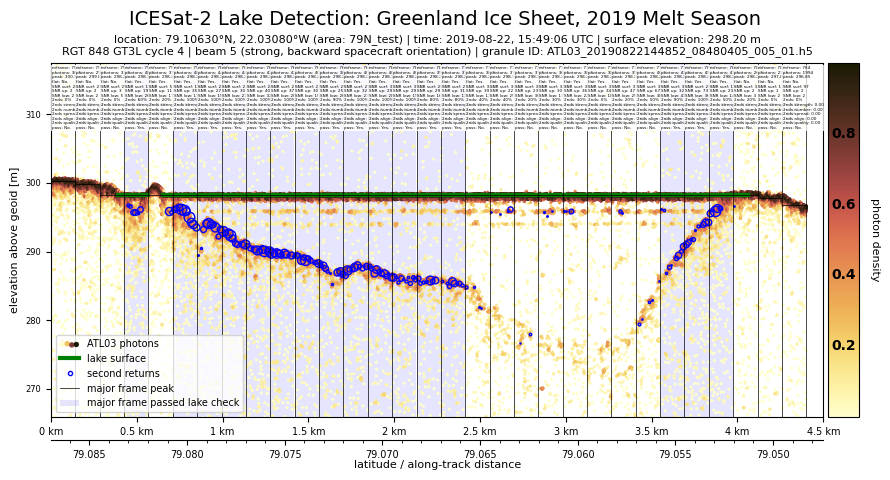

          lake_depth: 11.94 m -->  1.00
         lake_length:  3587 m -->  1.00
strength_2nd_returns:              0.70
      qual_alignment:              0.85
       TOTAL QUALITY:              0.49
____________________________________________________________________________________________
 


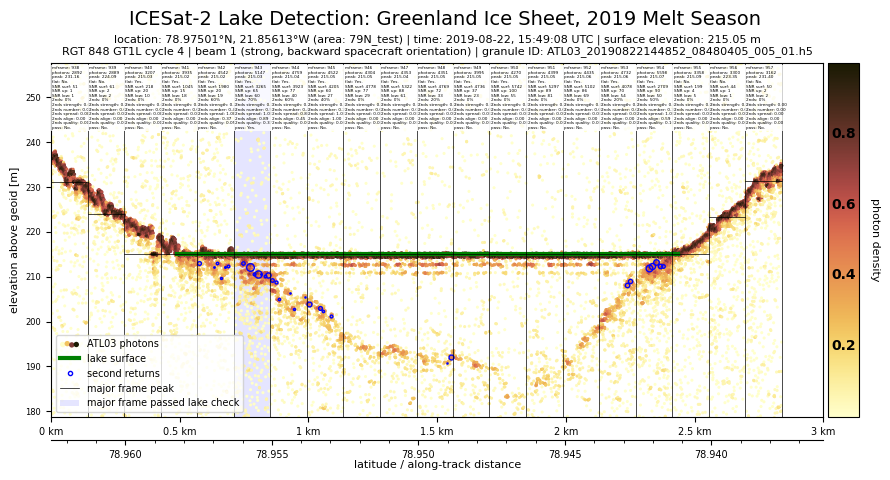

          lake_depth: 10.93 m -->  1.00
         lake_length:  1943 m -->  0.80
strength_2nd_returns:              0.46
      qual_alignment:              0.80
       TOTAL QUALITY:              0.17
____________________________________________________________________________________________
 


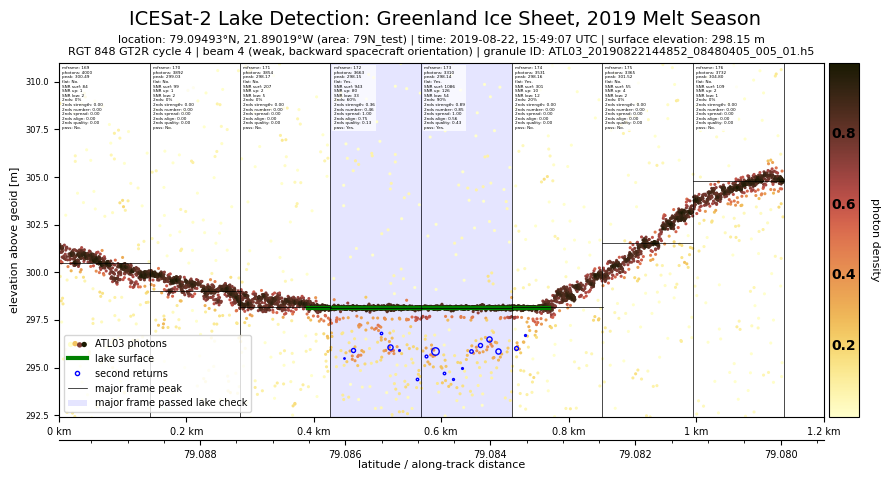

          lake_depth:  3.05 m -->  0.31
         lake_length:   378 m -->  0.35
strength_2nd_returns:              0.61
      qual_alignment:              0.48
       TOTAL QUALITY:              0.04
____________________________________________________________________________________________
 


In [76]:
plt.ioff()
for lake in lakelist:
    fig = plot_detected(lake)
    display(fig)
    calc_quality_lake(lake)

In [48]:
np.percentile(lakelist[1].surface_elevation - lakelist[1].detection_2nd_returns['h'],70)

10.133969235576785

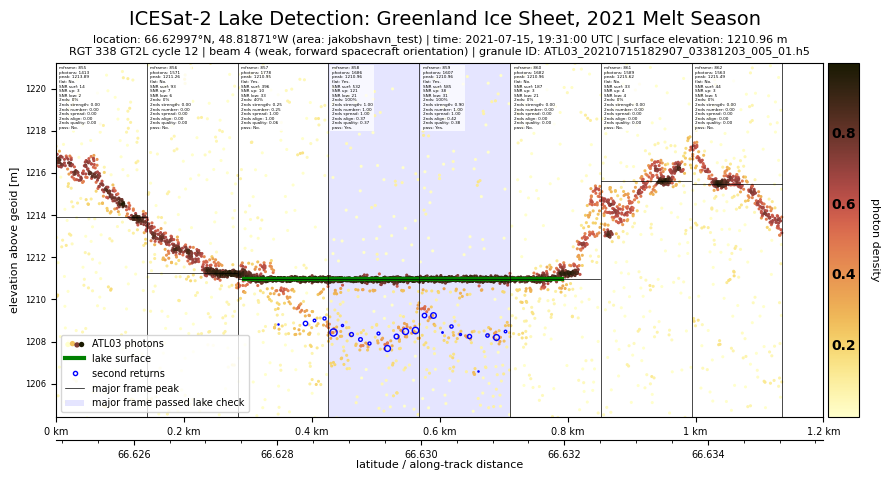

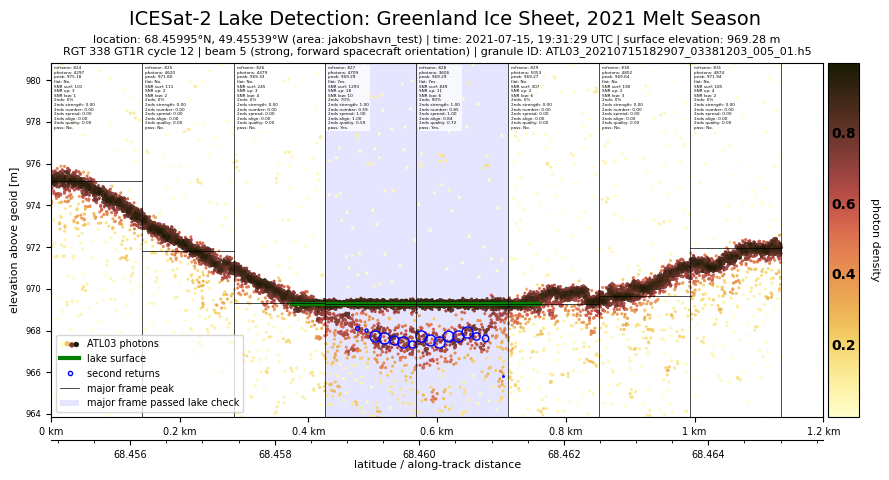

None

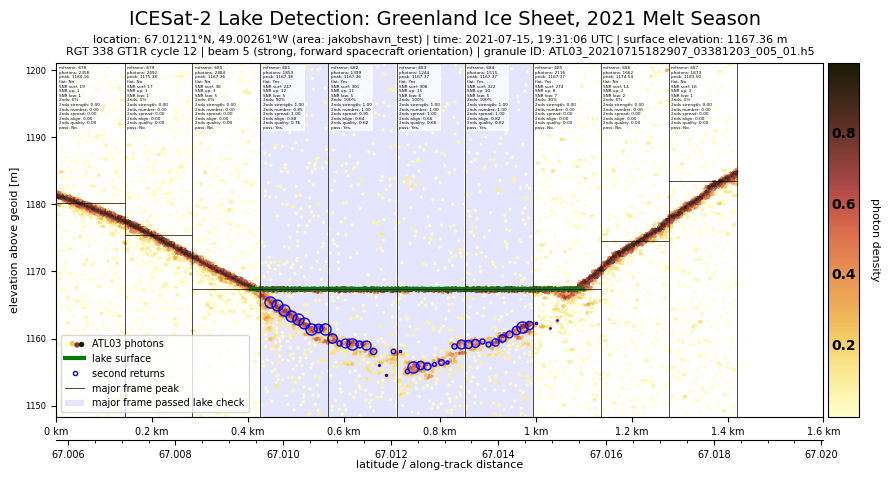

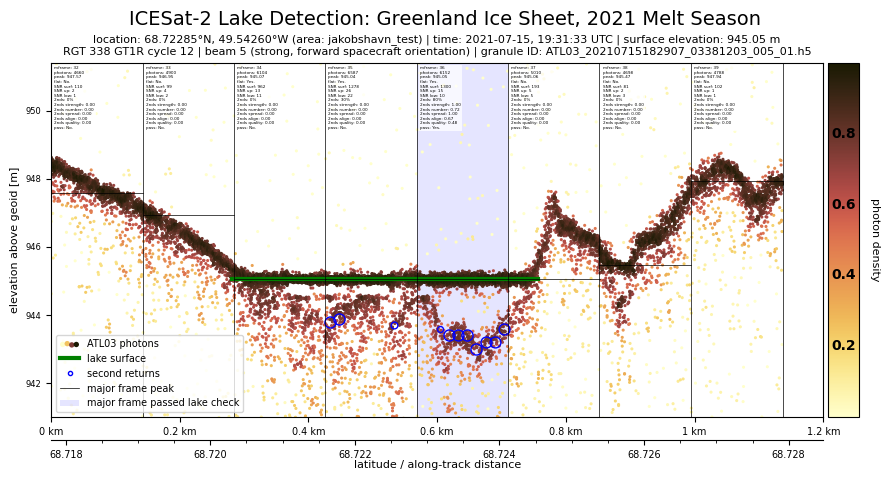

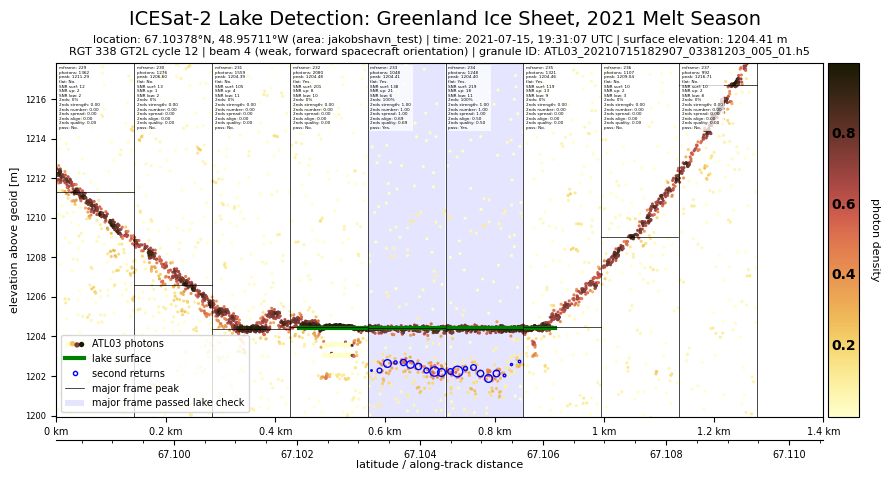

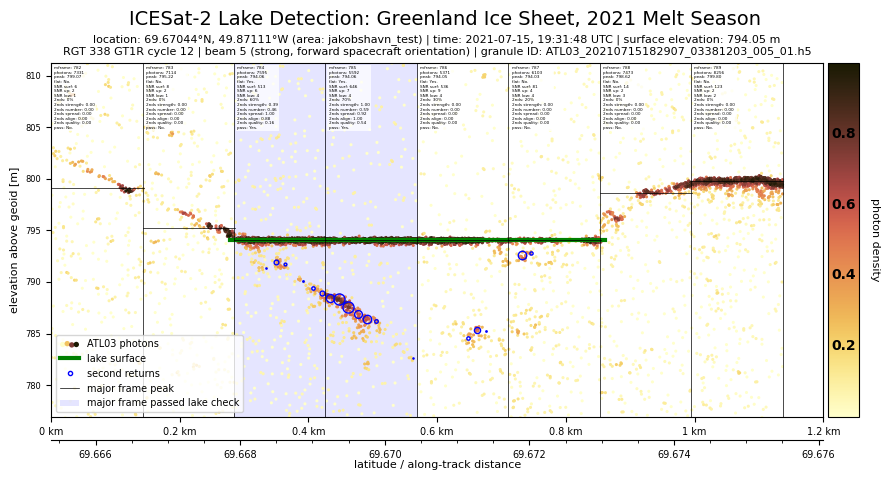

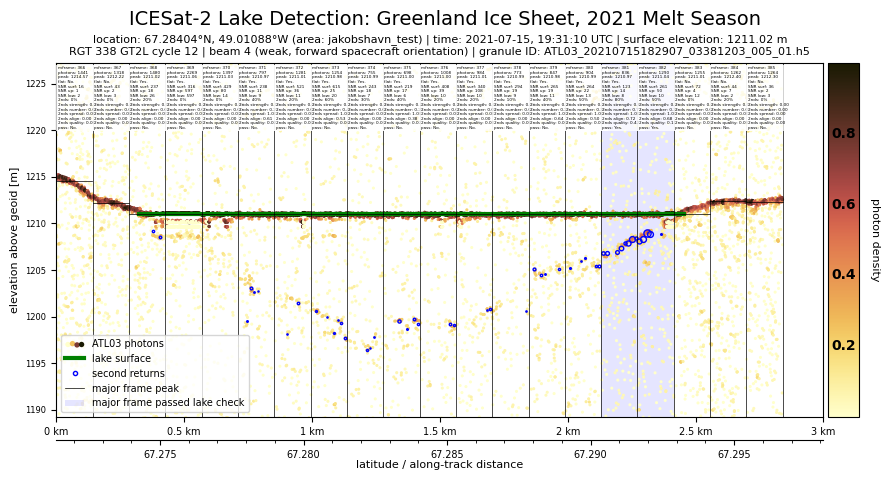

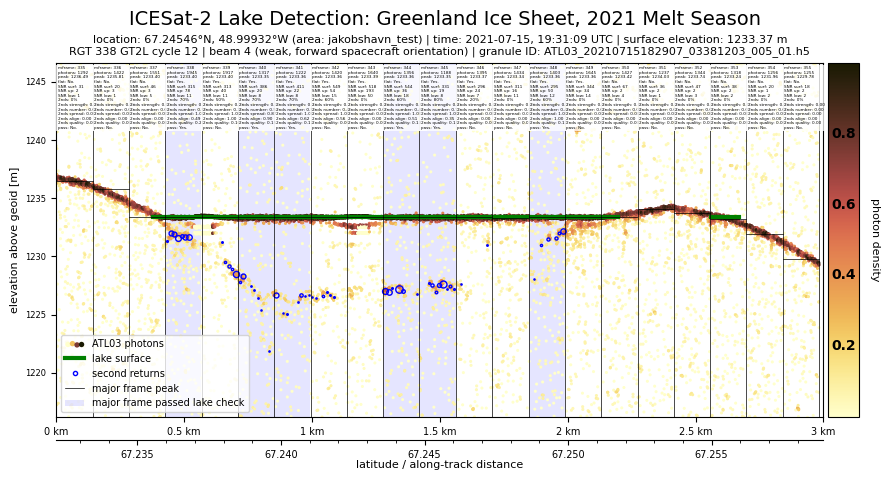

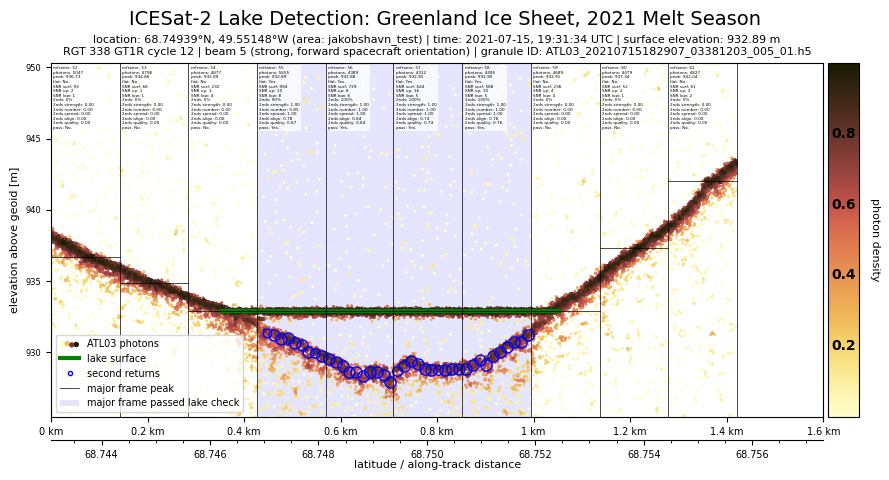

In [13]:
plt.ioff()
for lake in lakelist:
    fig = plot_detected(lake)
    display(fig)